# My Body Weight Project

## Introduction
This part briefly explains the objectives of this project.
I was fat for as long as I could remember before 2014, my body weight was constantly over 230lbs and reached a peak over 250lbs in the year of 2014.  
Thats when I finally decided to lose weight.
I did lots of researches online and tried out so many different stuff myself and finally successfully lost 100 lbs in a year and began my fitness journey ever since.   
I got my personal trainer certificate from American Council on Exercise (ACE) and I am a certifited nutritional specialist from ACE as well. I learned how to be fit and stay fit.   
Thats when I started to monitor my body weight constantly. I lost a year or two of body weight data initially because I was using another app.   
However, with the current body weight recording app I managed to get over 6 years of my body weight data and I am very interested to find out what I can discover with the Machine Learning techniques I recently aquired.  
Below is a picture of my personal body transformation of before and after. Check it out!!

<img src="https://raw.githubusercontent.com/DericMei/Body-Weight-Project/main/Pictures/IMG_0260.JPG" width="800" height="500"/>

## Import Packages


In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import streamlit as st
import joblib

## Data Preparation

### Loading data
some basic clean ups

In [226]:
# read raw data
df = pd.read_csv('My Body Weight.csv')
df.head()

,type,sourceName,sourceVersion,productType,device,startDate,endDate,unit,value,HKWasUserEntered,HKExternalUUID
0,HKQuantityTypeIdentifierBodyMass,Health,10.0.2,"iPhone8,2",NaN,2016-09-28 18:24:46 +0000,2016-09-28 18:24:46 +0000,kg,77.110640,NaN,NaN
1,HKQuantityTypeIdentifierBodyMass,Zijie的 iPhone,11.1.2,"iPhone10,3",NaN,2017-12-18 06:09:09 +0000,2017-12-18 06:09:09 +0000,kg,80.000000,NaN,NaN
2,HKQuantityTypeIdentifierBodyMass,Zijie的 iPhone,11.2.2,"iPhone10,3",NaN,2018-04-26 01:38:50 +0000,2018-04-26 01:38:50 +0000,kg,83.000000,NaN,NaN
3,HKQuantityTypeIdentifierBodyMass,Zijie的 iPhone,11.2.2,"iPhone10,3",NaN,2018-05-07 17:26:47 +0000,2018-05-07 17:26:47 +0000,kg,83.000000,NaN,NaN
4,HKQuantityTypeIdentifierBodyMass,Health,11.3.1,"iPhone10,3",NaN,2018-05-08 23:53:00 +0000,2018-05-08 23:53:00 +0000,kg,82.372374,1.0,NaN


In [227]:
# since I am only interested in the date and weight I am only keeping these 2 rows
df = df[['startDate', 'value']]

In [228]:
# renaming columns
df = df.rename(columns={'startDate': 'date', 'value': 'weight'})

In [229]:
# changing the formate of the date column
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
df

,date,weight
0,2016-09-28,77.110640
1,2017-12-18,80.000000
2,2018-04-26,83.000000
3,2018-05-07,83.000000
4,2018-05-08,82.372374
...,...,...
1347,2023-11-27,84.000000
1348,2023-11-28,84.599998
1349,2023-11-29,84.300003
1350,2023-11-30,84.599998


In [230]:
# Creating a function to plot weight over time easily later when cleaning up data

def plot_weight_over_time(df):
    # Make a copy of the dataframe to ensure the original data is not affected
    df_plot = df.copy()

    # Convert the 'date' column to datetime if it's not already
    df_plot['date'] = pd.to_datetime(df_plot['date'])
    
    # Ensure that the 'date' column is the index of the DataFrame for time series plotting
    df_plot.set_index('date', inplace=True)

    # Sort the DataFrame by the index (date) to ensure correct plotting
    df_plot.sort_index(inplace=True)

    # Plotting the data
    plt.figure(figsize=(15, 5))  # Adjust the size as needed
    plt.plot(df_plot.index, df_plot['weight'], marker='o', linestyle='-', color='green')

    # Improving the aesthetics
    plt.title('Weight Over Time')
    plt.xlabel('Date')
    plt.ylabel('Weight (kg)')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotates the date labels to avoid overlap

    # Handling missing values by breaking the line at missing dates
    plt.gca().set_prop_cycle(None)  # Reset the color cycle to reuse the first color

    # Show only the points where the 'weight' is not missing
    for date, weight in df_plot.dropna().iterrows():
        plt.plot(date, weight, marker='o', linestyle='', color='red')

    # Show the plot
    plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area.
    plt.show()

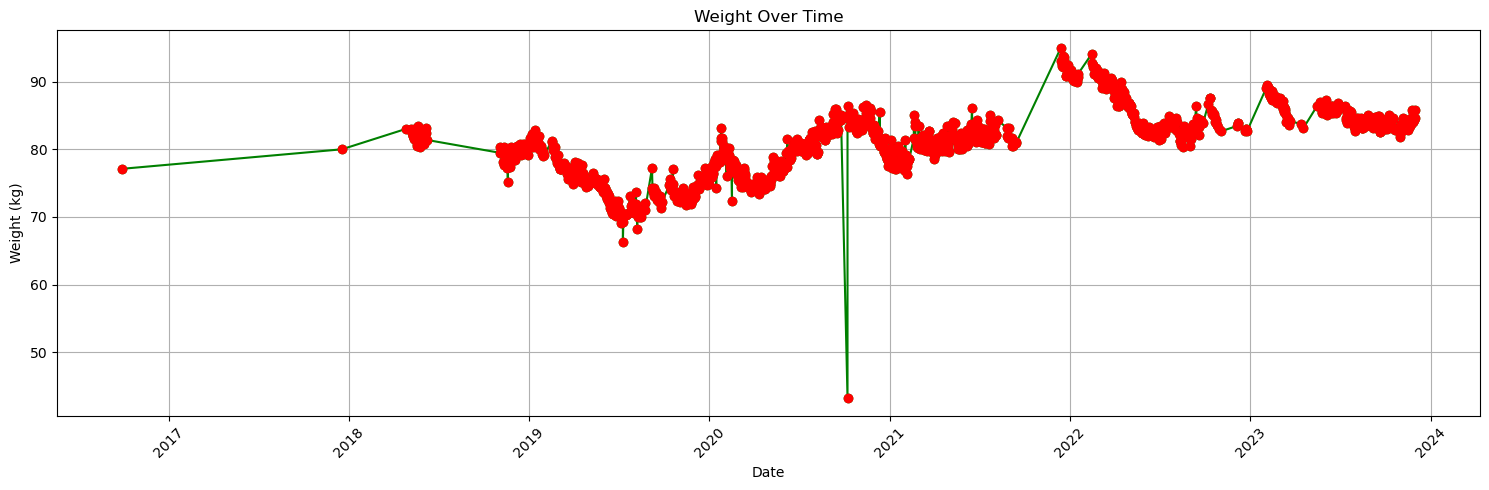

In [231]:
plot_weight_over_time(df)

There are tons of missing values here, shame on me for not recording consistantly T_T.
To handle these data and make my model more consistant, I need to do some processing with these data. 
- First I cannot seem to use any data before spring of 2018 because there is only 2 data points. 
- Second, there is one outlier in later 2020 where I recorded about 40 kg for my date, I think it might just be a typo when I was recording.
- Then because of some missing value in the middle here and there, I need to find a logic to fill up those missing values to make data more consistant.

### Further Data Clean up
Here is to further clean up the weight data to make it ready to model.

In [232]:
# Droping first 2 data points
df = df.drop(df.index[0:2])

In [233]:
# Droping the low data point in late 2020
df = df[df['weight'] > 50]

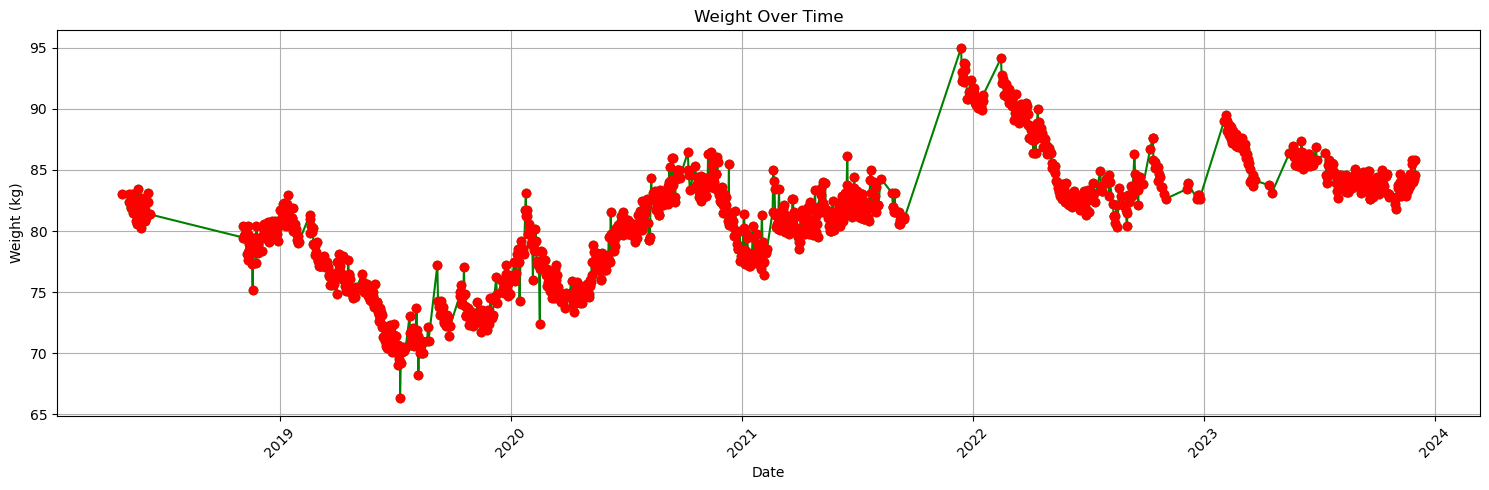

In [234]:
plot_weight_over_time(df)

Now the 3 extreme outliers has been handled. I need to then fill up all the missing values in between.

In [235]:
# write a function to fill in all the missing values for weight to make sure there is a weight value for each date.
# Basic logic here is for any missing weight, find the last recorded date and nearest next record and fill in with the linear relationship using the pandas interpolate function.

def fill_missing_values_with_interpolation(df, date_column='date', value_column='weight'):

    df_new = df.copy()

    # Ensure that 'date' is a datetime column
    df_new[date_column] = pd.to_datetime(df_new[date_column])
    
    # Drop duplicates, keeping only the first entry for each date
    df_new = df_new.drop_duplicates(subset=date_column)
    
    # Set 'date' as the DataFrame index
    df_new.set_index(date_column, inplace=True)
    
    # Create a continuous date range from the start date to the end date
    full_date_range = pd.date_range(start=df_new.index.min(), end=df_new.index.max(), freq='D')
    
    # Reindex the DataFrame with the full date range
    df_new = df_new.reindex(full_date_range)
    
    # Interpolate missing 'weight' values using a time-weighted method
    df_new[value_column] = df_new[value_column].interpolate(method='time')
    
    # Reset the index to turn the 'date' back into a column
    df_new.reset_index(inplace=True)
    
    # Rename the index back to 'date'
    df_new.rename(columns={'index': date_column}, inplace=True)
    
    return df_new

In [236]:
# use the function to create a new dataframe that has continuous weight data
df_final = fill_missing_values_with_interpolation(df)

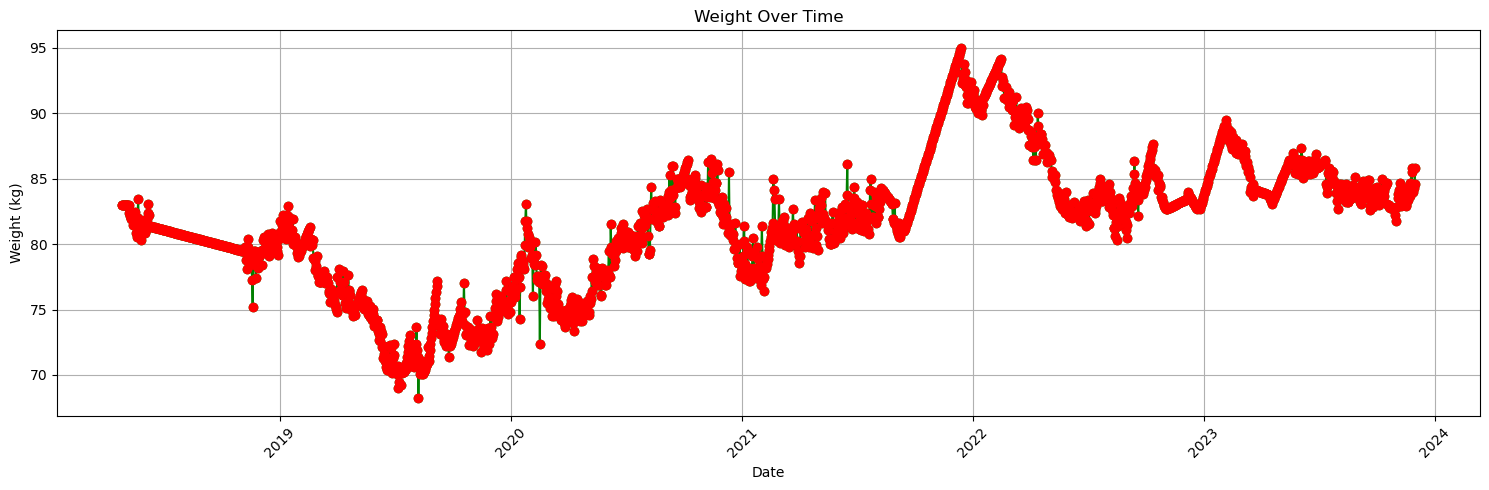

In [237]:
# plotting the dataframe to see if it is correct
plot_weight_over_time(df_final)

From the plot, it is pretty clear that all the issues has been fixed, and the data is already been cleaned up. Now I am ready to move on to the next stage.

### Exploratory Data Analysis (EDA)
Honestly, for this data, I really do not need much work in this area for several reasons:
- This is my own body weight data, I know exactly what happened at each stage and the reason behind (e.g. the peek in late 2021 is because my daugher was born and I did not have time to manage my body weight).
- The data is pretty simple and easy without much further need for interpretation.
However, I am still going to try to do some EDA here by plotting weekly or monthly weight averages to see if there is any trends.

In [238]:
# make a copy of the cleaned data frame and set the 'date' column as the index
df_eda = df_final.copy()
df_eda.set_index('date', inplace = True)

In [239]:
# Defining a function to make an interactive plot to further explore the cleaned data

def interactive_time_series(df, value_column='weight'):
    # Create the interactive plot
    fig = px.line(df, x=df.index, y=value_column, title='Weight Over Time')

    # Add range slider and buttons for predefined time intervals
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        )
    )

    # Show the plot
    fig.show()

In [240]:
# Plot using the function
interactive_time_series(df_eda)

Using this interactive plot I can easily track each part of the trends and anomlies with the weight data. I just learned this by myself and it is really cool! Here I can easily discover a few very obvious trends:
- For each year, my weight reaches the lowest early summer and keeps there for a while, mostly for the entire summer to early fall.
- Starting fall, my weight begins to slowly increase until mid winter.
- Then my weight will go on a roller coaster ride and sky rocket up around the second half of the winter.
- In the end, my weight will then slowly decrease to another low point from early spring to early summer.
- Overall, my body weight is going up yearly.
You might have guessed it already, this is the typical body weight trend for a bodybuilding lifestyle. I will start my yearly cut after the holiday season every year until early summer. Maintain my good six-pack body for the summer, and slowly bulk during the fall and go on a happy binge eating streak during the holiday season in the winter.

## Data Splitting/Loading/Batching
Out of all the machine learning techniques I have learned so far, there is nothing better than a LSTM model that can run my time series prediction here. I am going to prepare the data here before modeling with the LSTM model, which includes data normalizing, splitting, loading, and batching.

### Data normalization
LSTM models are sensitive to the scale of the input data, thats why I need to normalize the data first before training the model.

In [241]:
# Create a copy of the data frame
df_model = df_final.copy()

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape data to fit the scaler's expected format
data = df_model['weight'].values.reshape(-1, 1)

# Fit the scaler to your data and transform it
normalized_data = scaler.fit_transform(data)

# Replace the original 'weight' data with the normalized data
df_model['weight_normalized'] = normalized_data


In [410]:
# Save the scalar
joblib.dump(scaler, 'weight_scaler.pkl')

['weight_scaler.pkl']

In [242]:
df_model

,date,weight,weight_normalized
0,2018-04-26,83.000000,0.551900
1,2018-04-27,83.000000,0.551900
2,2018-04-28,83.000000,0.551900
3,2018-04-29,83.000000,0.551900
4,2018-04-30,83.000000,0.551900
...,...,...,...
2041,2023-11-27,84.000000,0.589241
2042,2023-11-28,84.599998,0.611646
2043,2023-11-29,84.300003,0.600444
2044,2023-11-30,84.599998,0.611646


### Create sequence
The end goal here for me is to predict my body weight using 7 previous days of body weight data. Therefore I need to create sequence data here.

In [305]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x.reshape(-1, 1))
        ys.append(y.reshape(-1, ))
    return np.array(xs), np.array(ys)

In [306]:
# using normalized weights for creating the sequence
bw = df_model['weight_normalized'].values
# Create the sequences (using 7 days)
X, y = create_sequences(bw, 7)

In [307]:
# X is now an array of 7-day sequences of weight
# y is the weight of the next day for each sequence
X.shape, y.shape

((2039, 7, 1), (2039, 1))

### Train/Validation/Testing split
For time series data like this, I am not randomly splitting data, instead, I am picking the last 20% of the data and use half of them as validation and half of them as testing data, because the order of time is important in a time series prediction like this

In [308]:
# Define the proportions
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Calculate the indices for the splits
train_idx = int(len(X) * train_size)
val_idx = int(len(X) * (train_size + val_size))

# Split the features
X_train, X_val, X_test = X[:train_idx], X[train_idx:val_idx], X[val_idx:]

# Split the targets
y_train, y_val, y_test = y[:train_idx], y[train_idx:val_idx], y[val_idx:]

In [309]:
# Check the shape to make sure they are all in the correct format
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1631, 7, 1) (204, 7, 1) (204, 7, 1)
(1631, 1) (204, 1) (204, 1)


### Tensor transform, data loading, and batching

In [310]:
# Define a custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Create data loaders
batch_size = 32  # Adjust as per your requirements
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [311]:
# obtain one batch of training data to check
dataiter_train = iter(train_loader)
features, labels = next(dataiter_train)

print('Sample input size: ', features.size()) # batch_size, seq_length
print()
print('Sample label size: ', labels.size()) # batch_size

Sample input size:  torch.Size([32, 7, 1])

Sample label size:  torch.Size([32, 1])


## Modeling
Here I will build and train my LSTM model.

### Define functions

In [279]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1, num_layers=1, dropout_prob=0.5):
        super().__init__()
        # Define the LSTM architecture
        self.lstm = nn.LSTM(input_dim, hidden_dims, num_layers=num_layers,
                            dropout=dropout_prob, batch_first=True)
        self.output_layer = nn.Linear(hidden_dims, output_dim)

    def forward(self, x):
        # Pass the input through the LSTM layers
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Take the last hidden state for the last time step
        last_time_step = lstm_out[:, -1, :]
        # Pass the last hidden state of the last time step through the output layer
        x = self.output_layer(last_time_step)
        return x

In [280]:
# Define the function to factorilize the training and validation stage

class LSTMFactorization:
    def __init__(self, input_dim, hidden_dims, learning_rate=1e-2, num_layers=1,
                 dropout_prob=0.5, device=None, n_iter=10, l2=0.0,scaler=None, random_state=None):
        self._learning_rate = learning_rate
        self._n_iter = n_iter
        self._l2 = l2
        self._device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self._model = LSTMModel(input_dim, hidden_dims, num_layers=num_layers,
                                dropout_prob=dropout_prob).to(self._device)
        self._optimizer = optim.Adam(self._model.parameters(), lr=self._learning_rate, weight_decay=self._l2)
        self._loss_func = nn.MSELoss()
        self._scaler = scaler
        self._random_state = random_state or np.random.RandomState()

    ##############
    ###Training###
    ##############
    def fit(self, train_loader, val_loader, verbose=True):

        valid_loss_min = np.Inf # track change in validation loss
        train_losses, valid_losses, valid_rmse_original =[], [], [] # track train losses, valid loss, and RMSE over epoches

        for epoch in range(self._n_iter):
            self._model.train()
            total_train_loss = 0

            for features, labels in train_loader:

                #1. Get predicted ratings using the model
                output = self._model(features)
                #2. Calculate loss using the loss function we just defined
                loss = self._loss_func(output, labels)
                #3. Zero out gradients
                self._optimizer.zero_grad()
                #4. Compute gradients
                loss.backward()
                #5. Update weights
                self._optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            avg_val_loss, avg_val_rmse_original = self.validate(val_loader)  

            # save train/validation loss and accuracy
            train_losses.append(avg_train_loss)
            valid_losses.append(avg_val_loss)
            valid_rmse_original.append(avg_val_rmse_original)

            # print progress
            if verbose:
                print('Epoch {}: loss_train {}, loss_val {}, rmse_val_original {}'.format(epoch, avg_train_loss, avg_val_loss, avg_val_rmse_original))

            if np.isnan(avg_train_loss) or avg_train_loss == 0.0:
                raise ValueError('Degenerate train loss: {}'.format(avg_train_loss))

            # save model if validation loss has decreased
            if avg_val_loss < valid_loss_min:
                print(f'Validation loss decreased ({valid_loss_min:.6f} --> {avg_val_loss:.6f}). Saving model...')
                torch.save(self._model.state_dict(), 'model_lstm.pth')
                valid_loss_min = avg_val_loss

        return train_losses, valid_losses, valid_rmse_original

    ################
    ###Validation###
    ################
    def validate(self, val_loader, verbose=False):
        self._model.eval()
        total_val_loss = 0
        total_val_rmse_original = 0

        with torch.no_grad():
            for features, labels in val_loader:

                #1. Calculate Predictions
                output = self._model(features)
                #2. Calculate Loss
                loss = self._loss_func(output, labels)
                total_val_loss += loss.item()

                # Denormalize predictions and actual values
                output_denorm = self._scaler.inverse_transform(output.cpu().numpy())
                labels_denorm = self._scaler.inverse_transform(labels.cpu().numpy())

                # Calculate RMSE on the original scale
                rmse_original = np.sqrt(np.mean((output_denorm - labels_denorm) ** 2))
                total_val_rmse_original += rmse_original

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_rmse_original = total_val_rmse_original / len(val_loader)

        if verbose:
            print(f"Validation Loss: {avg_val_loss}")
            print(f"Validation RMSE (Original): {avg_val_rmse_original}")

        return avg_val_loss, avg_val_rmse_original  

In [281]:
# Define a function to plot train and valid losses
import matplotlib.pyplot as plt
def plot_losses(train_losses, valid_losses, num_epochs):
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, num_epochs + 1), train_losses, label='train')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='validation')
    plt.title('Plot of training and validation Losses')
    plt.xlabel('epoch')
    plt.ylabel('Losses')
    plt.legend()
    plt.show()

### Train the model

In [396]:
# Create the model instance
lstm_factorization_model = LSTMFactorization(input_dim=1,
                                             hidden_dims=32,
                                             learning_rate=0.0008,
                                             num_layers=1,
                                             dropout_prob=0,
                                             n_iter=200,
                                             l2=0.0001,
                                             scaler=scaler)

In [397]:
# Now train the model
train_losses, valid_losses, valid_rmse = lstm_factorization_model.fit(train_loader, val_loader)

Epoch 0: loss_train 0.163631737049596, loss_val 0.003418638722255959, rmse_val_original 1.2934402142252241
Validation loss decreased (inf --> 0.003419). Saving model...
Epoch 1: loss_train 0.021848013204540693, loss_val 0.00812384976805853, rmse_val_original 2.191322156361171
Epoch 2: loss_train 0.009882830667729471, loss_val 0.001886346036501761, rmse_val_original 1.0710336225373405
Validation loss decreased (0.003419 --> 0.001886). Saving model...
Epoch 3: loss_train 0.0023425036479773767, loss_val 0.0006665300544617432, rmse_val_original 0.6681478108678546
Validation loss decreased (0.001886 --> 0.000667). Saving model...
Epoch 4: loss_train 0.001605993352474316, loss_val 0.00047395704314112663, rmse_val_original 0.563609208379473
Validation loss decreased (0.000667 --> 0.000474). Saving model...
Epoch 5: loss_train 0.0014993558288551867, loss_val 0.0003909130973624997, rmse_val_original 0.5035676232406071
Validation loss decreased (0.000474 --> 0.000391). Saving model...
Epoch 6: l

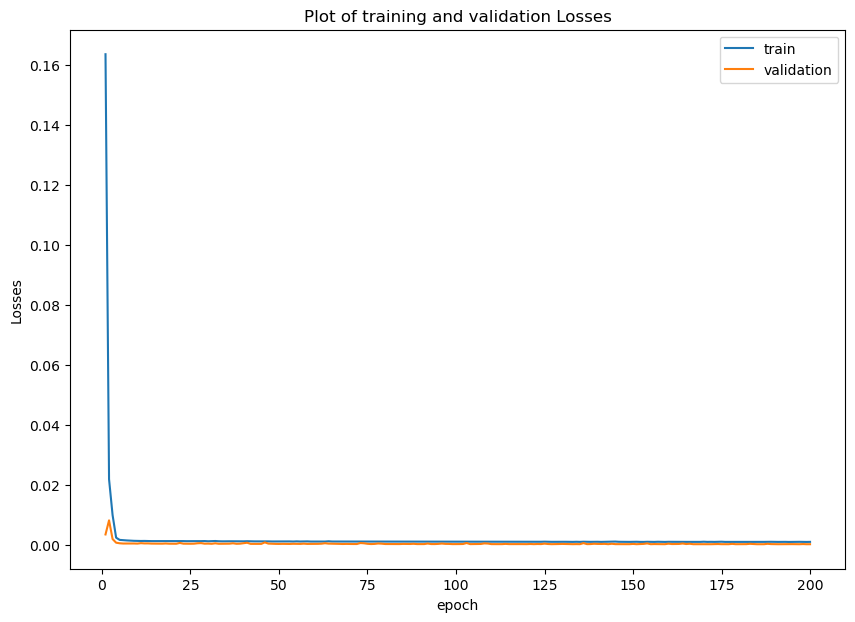

In [398]:
# Plot the train and valid losses for 100 epochs training
plot_losses(train_losses, valid_losses, num_epochs=200)

In [399]:
test_loss, test_rmse = lstm_factorization_model.validate(test_loader, verbose = True)

Validation Loss: 0.0004961086960975081
Validation RMSE (Original): 0.5890956733907972


## Deployment
- My goal here is to first create a interactive visualization to show all the predictions against the original data, trying to see how well my model is performing.
- Then I want to try to figure out a way to create an app or dashboard that will display the same interactive visulization that have a function that I can entire 7 weight point data of myself and get the predicted weight of me of the next day.

### Interactive Visualization

In [400]:
# Load the saved model
model = LSTMModel(1, 32, num_layers=1, dropout_prob=0)  # Initialize the model with the same parameters
model.load_state_dict(torch.load('model_lstm.pth'))
model.eval()  # Set to evaluation mode

LSTMModel(
  (lstm): LSTM(1, 32, batch_first=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [401]:
# Create dataset with the entire data
all_dataset = TimeSeriesDataset(X, y)

# Create data loaders
batch_size = 32
all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False)

In [402]:
# Get predictions for all data points
all_predictions = []
with torch.no_grad():
    for sequences, _ in all_loader:
        predictions = model(sequences)
        all_predictions.extend(predictions.cpu().numpy())

# Denormalize the predictions if your data was normalized
all_predictions_original = scaler.inverse_transform(all_predictions)

In [403]:
all_predictions_original

array([[83.04785759],
       [83.04785759],
       [83.04785759],
       ...,
       [84.71563399],
       [84.56714795],
       [84.60171674]])

In [404]:
# Create a timeline for the entire dataset
timeline = pd.date_range(start='2018-04-26', periods=len(all_predictions_original), freq='D')

original_weights = df_model['weight'].values

# Create traces with color coding
trace_train = go.Scatter(x=timeline[:len(X_train)], y=all_predictions_original[:len(X_train)].flatten(), mode='lines', name='Training', line=dict(color='green'))
trace_val = go.Scatter(x=timeline[len(X_train):len(X_train)+len(X_val)], y=all_predictions_original[len(X_train):len(X_train)+len(X_val)].flatten(), mode='lines', name='Validation', line=dict(color='orange'))
trace_test = go.Scatter(x=timeline[-len(X_test):], y=all_predictions_original[-len(X_test):].flatten(), mode='lines', name='Testing', line=dict(color='red'))
trace_original = go.Scatter(x=timeline, y=original_weights, mode='lines', name='Actual', line=dict(color='yellow'))

# Create the figure
fig = go.Figure(data=[trace_train, trace_val, trace_test, trace_original])

# Add titles and labels
fig.update_layout(title='Predictions vs. Original Data',
                  xaxis_title='Date',
                  yaxis_title='Weight (kg)',
                  hovermode="x")

# Add interactive slider and buttons
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Show the figure
fig.show()


### Actually deploying
I am going to use Streamlit to deploy a demo app to display my model. Codes will be in the app.py file.